Checking the accuracy of the algorithmic tracking, excluding the "Other" category

In [1]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.misc
import krippendorff
from tabulate import tabulate

Load the ratings of the algorithm and the raters

In [2]:
# Load data from algorithmic tracking
raterFiles = glob.glob("data/P*.txt")
df_algoFiles = (pd.read_csv(f, header = None) for f in raterFiles)
df_algo   = pd.concat(df_algoFiles, ignore_index=True, axis = 0)

# Load data from manual ratings
raterFiles = glob.glob("data/data_Rater*.csv")
df_raterFiles = (pd.read_csv(f, header = 0) for f in raterFiles)
df_rater   = pd.concat(df_raterFiles, ignore_index=True)

Prepare the data to get it into long format

In [3]:
# Only take the last judgement of each rater
df_rater.drop_duplicates(subset=['Rater', 'Frame', 'Trial'], keep='last', inplace = True)

# Rename columns
df_algo.columns = ["Trial", "Label", "1", "2", "3", "4", "5", "6", "VisiblePoints", "7", "8" ]

# Add frame number column
df_algo["Frame"] = df_algo.groupby(['Trial']).cumcount()

# Add column for rater
df_algo['Rater'] = 'Algorithm'

# Set datatypes
df_algo["Trial"] = df_algo["Trial"].astype("string")
df_algo["Frame"] = df_algo["Frame"].astype("string")
df_algo["Label"] = df_algo["Label"].astype("string")
df_rater["Frame"] = df_rater["Frame"].astype("string")
df_rater["Trial"] = df_rater["Trial"].astype("string")
df_rater["Label"] = df_rater["Label"].astype("string")

# Rename the labels to match the AOI from the algorithmic approach
df_algo['Label'] = df_algo['Label'].str.replace("Nose","Head")
df_algo['Label'] = df_algo['Label'].str.replace("Neck","Chest")
df_algo['Label'] = df_algo['Label'].str.replace("LElbow","Left arm")
df_algo['Label'] = df_algo['Label'].str.replace("RElbow","Right arm")
df_algo['Label'] = df_algo['Label'].str.replace("RKnee","Right leg")
df_algo['Label'] = df_algo['Label'].str.replace("LKnee","Left leg")
df_algo['Label'] = df_algo['Label'].str.replace("MidHip","Pelvis")

# Check the unique values
# df_algo['Label'].unique()

Merge the data into Long format

In [4]:
# Merge data frames
df = pd.concat([df_algo, df_rater], join='outer', keys=['Trial', 'Frame', 'Rater', 'Label']).reset_index(drop=True)

# only keep rows where all ratings are available
def filterRows(group):
    if group.shape[0] > 1:
        return group

df = df.groupby(['Trial', 'Frame']).apply(filterRows).reset_index(drop=True)

df.ffill(inplace=True)
df = df[['Trial', 'Label', 'VisiblePoints', 'Frame', 'Rater']]

df.drop(columns=['VisiblePoints'], inplace=True)
df.to_csv("results/data_noOther.csv", index=False)

Drop all frames where any rating was "Other"

In [5]:
def filterOther(group):
    if not (group.Label == "Other").any(): # If no "other" is in the data, return the group
        return group

df = df.groupby(['Trial', 'Frame']).apply(filterOther).reset_index(drop=True)

Calculate the Rater agreement among the human raters



In [6]:
# Create rating agreements between raters and algorithm, and among raters. Need data in wide format for this
df = df.pivot(index=['Trial', 'Frame'], columns='Rater', values='Label')

# Drop nans
df.dropna(inplace=True)

# Columns with comparison values
rater1_Algorithm = df.Rater1 == df.Algorithm
rater2_Algorithm = df.Rater2 == df.Algorithm
rater3_Algorithm = df.Rater3 == df.Algorithm
rater1_rater2 = df.Rater1 == df.Rater2
rater1_rater3 = df.Rater1 == df.Rater3
rater2_rater3 = df.Rater2 == df.Rater3
manualRaters = (
    (df.Rater1 == df.Rater2) &
    (df.Rater1 == df.Rater3) &
    (df.Rater2 == df.Rater3))

# Calculate the rating agreement
rater1_algorithm_pct = ((rater1_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater2_algorithm_pct = ((rater2_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater3_algorithm_pct = ((rater3_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater1_rater2_pct = ((rater1_rater2.astype(int).sum() / df.shape[0]) * 100)
rater1_rater3_pct = ((rater1_rater3.astype(int).sum() / df.shape[0]) * 100)
rater2_rater3_pct = ((rater2_rater3.astype(int).sum() / df.shape[0]) * 100)
rater_all_pct = ((manualRaters.astype(int).sum() / df.shape[0]) * 100)

# Back to long format
df = df.stack().rename('Label').reset_index(['Frame', 'Trial', 'Rater'])

Calculate agreement among all raters (humans AND algorithm)

In [32]:
ratingList = []

df_among = df.copy()
df_among['Label_ID'], _ = pd.factorize(df_among.Label)

def append_to_list(group):
    ratingList.append(group.Label_ID.to_list())

df_among.groupby(['Trial', 'Frame']).apply(append_to_list)
kappa_allRaters = krippendorff.alpha(np.array(ratingList).T)

print(f"Average agreement amont manual raters is {kappa_allRaters:.2f}")

Average agreement amont manual raters is 0.61


Calculate agreement among human raters 

In [33]:
ratingList = []

df_all = df.copy()

df_humans = df_all.loc[df.Rater != "Algorithm", :]
df_humans['Label_ID'], _ = pd.factorize(df_humans.Label)

def append_to_list(group):
    ratingList.append(group.Label_ID.to_list())

df_humans.groupby(['Trial', 'Frame']).apply(append_to_list)
kappa_manualRaters = krippendorff.alpha(np.array(ratingList).T)

print(f"Average agreement amont manual raters is {kappa_manualRaters:.2f}")

Average agreement amont manual raters is 0.62
<ipython-input-33-6ec22a95c013>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_humans['Label_ID'], _ = pd.factorize(df_humans.Label)


For between rater agreement between two raters, cohens Kappa can be used (e.g. the algorithm compared to rater1)

[Source](https://stackoverflow.com/questions/11528150/inter-rater-agreement-in-python-cohens-kappa)

In [34]:
from sklearn.metrics import cohen_kappa_score

ratingList = []
df_between = df.copy()
df_between['Label_ID'], _ = pd.factorize(df_between.Label)

algorithm = df_between.loc[df_between.Rater == "Algorithm", 'Label_ID']
rater1 = df_between.loc[df_between.Rater == "Rater1", 'Label_ID']
rater2 = df_between.loc[df_between.Rater == "Rater2", 'Label_ID']
rater3 = df_between.loc[df_between.Rater == "Rater3", 'Label_ID']

rater1_rater2_kappa = cohen_kappa_score(rater1, rater2)
rater1_rater3_kappa = cohen_kappa_score(rater1, rater3)
rater2_rater3_kappa = cohen_kappa_score(rater2, rater3)
rater1_algorithm_kappa = cohen_kappa_score(algorithm, rater1)
rater2_algorithm_kappa = cohen_kappa_score(algorithm, rater2)
rater3_algorithm_kappa = cohen_kappa_score(algorithm, rater3)


In [35]:
# Create table
table = [
    ["Comparison all AOI", "Percent agreement [%]", "Reliability [Cohens Kappa]"],
    ["Rater 1 vs. Algorithm", rater1_algorithm_pct, rater1_algorithm_kappa],
    ["Rater 2 vs. Algorithm", rater2_algorithm_pct, rater2_algorithm_kappa],
    ["Rater 3 vs. Algorithm", rater3_algorithm_pct, rater3_algorithm_kappa],
    ["Rater 1 vs. Rater 2", rater1_rater2_pct, rater1_rater2_kappa],
    ["Rater 1 vs. Rater 3", rater1_rater3_pct, rater1_rater3_kappa],
    ["Rater 2 vs. Rater 3", rater2_rater3_pct, rater2_rater3_kappa],
    ["Among all raters", "Not implemented yet" , kappa_allRaters],
    ["Among human raters", rater_all_pct , kappa_manualRaters],

]

tabulate_table = tabulate(
    table,
    headers="firstrow",
    floatfmt=".2f",
    tablefmt="github")

tabulate_table = tabulate(
    table,
    headers="firstrow",
    floatfmt=".2f",
    tablefmt="latex")

print(tabulate_table)

# Save table
with open('results/Reliability_NoOther.txt', 'w') as f:
    f.write(tabulate_table)

# Save data
df.to_csv("results/data_noOther.csv")

\begin{tabular}{llr}
\hline
 Comparison all AOI    & Percent agreement [\%]   &   Reliability [Cohens Kappa] \\
\hline
 Rater 1 vs. Algorithm & 86.41618497109826       &                         0.70 \\
 Rater 2 vs. Algorithm & 71.67630057803468       &                         0.50 \\
 Rater 3 vs. Algorithm & 80.63583815028902       &                         0.61 \\
 Rater 1 vs. Rater 2   & 79.76878612716763       &                         0.64 \\
 Rater 1 vs. Rater 3   & 86.70520231213872       &                         0.73 \\
 Rater 2 vs. Rater 3   & 75.0                    &                         0.57 \\
 Among all raters      & Not implemented yet     &                         0.61 \\
 Among human raters    & 71.82080924855492       &                         0.62 \\
\hline
\end{tabular}


Average agreement between raters and algorithm and among raters

In [36]:
rater_vs_algorithm_pct = (rater1_algorithm_pct + rater2_algorithm_pct + rater3_algorithm_pct) / 3
rater_vs_algorithm_std = np.std([rater1_algorithm_pct, rater2_algorithm_pct, rater3_algorithm_pct])

rater_vs_rater_pct = (rater1_rater2_pct + rater1_rater3_pct + rater2_rater3_pct) / 3
rater_vs_rater_std = np.std([rater1_rater2_pct, rater1_rater3_pct, rater2_rater3_pct])

print(f"average rater-algorithm agreement {rater_vs_algorithm_pct}%, SD={rater_vs_algorithm_std}")
print(f"average rater-rater agreement {rater_vs_rater_pct}%, SD={rater_vs_rater_std}")



average rater-algorithm agreement 79.57610789980733%, SD=6.064009626919541
average rater-rater agreement 80.4913294797688%, SD=4.805863915698232


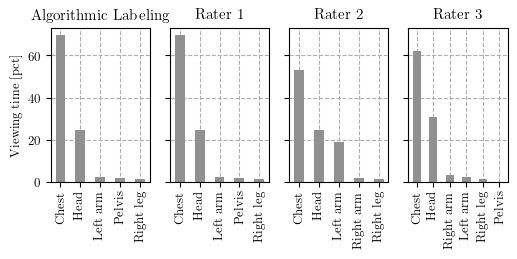

In [37]:
%matplotlib inline
mpl.style.use('default')

# The data
pct_algorithm = (df.loc[df.Rater == "Rater1", 'Label'].value_counts() / df.loc[df.Rater == "Rater1"].shape[0]) * 100
pct_rater1 = (df.loc[df.Rater == "Rater1", 'Label'].value_counts() / df.loc[df.Rater == "Rater1"].shape[0]) * 100
pct_rater2 = (df.loc[df.Rater == "Rater2", 'Label'].value_counts() / df.loc[df.Rater == "Rater2"].shape[0]) * 100
pct_rater3 = (df.loc[df.Rater == "Rater3", 'Label'].value_counts() / df.loc[df.Rater == "Rater3"].shape[0]) * 100

# Plot settings
# Requires on linux: sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
mpl.rcParams.update(
    {
        'font.family': 'serif',
        'text.usetex': True,
        'font.size': 9
    }
)

# Figure settings for export
LATEX_WIDTH_INCHES = 5.9

# Plot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (LATEX_WIDTH_INCHES, 2), sharey = True)

axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)
axes[2].set_axisbelow(True)
axes[3].set_axisbelow(True)

pct_algorithm.plot(kind = 'bar', ax = axes[0], color = '#909090')
pct_rater1.plot(kind = 'bar', ax = axes[1], color = '#909090')
pct_rater2.plot(kind = 'bar', ax = axes[2], color = '#909090')
pct_rater3.plot(kind = 'bar', ax = axes[3], color = '#909090')

axes[0].grid(linestyle='dashed')
axes[1].grid(linestyle='dashed')
axes[2].grid(linestyle='dashed')
axes[3].grid(linestyle='dashed')

# fig.suptitle("AOI classification (no 'Other')")
axes[0].set_ylabel("Viewing time [pct]")
axes[0].set_title("Algorithmic Labeling")
axes[1].set_title("Rater 1")
axes[2].set_title("Rater 2")
axes[3].set_title("Rater 3")

# Save
plt.savefig("plots/RaterComparison_NoOther.svg", bbox_inches='tight')
plt.savefig("../../article_gazeclassify/conference/images/RaterComparison_NoOther.svg", bbox_inches='tight')
